In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

# --- GPU SETUP ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"PyTorch Version: {torch.__version__}")
print(f"Using Device: {device}")

if device.type == 'cuda':
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print("Success! Your RTX 3050 is being used.")
else:
    print("Warning: Running on CPU.")

ModuleNotFoundError: No module named 'torch'

In [1]:
# --- PATHS ---
path_cases = '../../RAW_DATA/Virus/Covid_19/covid_19_india/covid_19_india.csv'
path_mob_2020 = '../../RAW_DATA/Transportion/2020_IN_Region_Mobility_Report.csv'
path_mob_2021 = '../../RAW_DATA/Transportion/2021_IN_Region_Mobility_Report.csv'
path_mob_2022 = '../../RAW_DATA/Transportion/2022_IN_Region_Mobility_Report.csv'

# --- 1. LOAD MOBILITY ---
try:
    df_m20 = pd.read_csv(path_mob_2020)
    df_m21 = pd.read_csv(path_mob_2021)
    df_m22 = pd.read_csv(path_mob_2022)
    mobility_full = pd.concat([df_m20, df_m21, df_m22])
    
    # Filter for INDIA National
    india_mob = mobility_full[(mobility_full['country_region_code'] == 'IN') & (mobility_full['sub_region_1'].isnull())].copy()
    india_mob['Date'] = pd.to_datetime(india_mob['date'])
    
    # Calc Average & Lag
    mob_cols = ['retail_and_recreation_percent_change_from_baseline', 
                'transit_stations_percent_change_from_baseline', 
                'workplaces_percent_change_from_baseline']
    
    # 7-Day Smooth + 14-Day Shift
    india_mob['Mobility_Avg'] = india_mob[mob_cols].mean(axis=1).rolling(7).mean().shift(14).fillna(0)
    
except Exception:
    india_mob = pd.DataFrame(columns=['Date', 'Mobility_Avg'])

# --- 2. LOAD CASES ---
df_cases = pd.read_csv(path_cases)
df_cases['Date'] = pd.to_datetime(df_cases['Date'], format='%Y-%m-%d')
india_cases = df_cases.groupby('Date')[['Confirmed']].sum().reset_index()
india_cases['New_Cases'] = india_cases['Confirmed'].diff().fillna(0).clip(lower=0)

# --- 3. MERGE ---
master_df = pd.merge(india_cases, india_mob[['Date', 'Mobility_Avg']], on='Date', how='left').fillna(0)
master_df = master_df.sort_values('Date').reset_index(drop=True)

print(f"Data Loaded: {len(master_df)} rows")

NameError: name 'pd' is not defined

In [4]:
# --- CONFIG ---
LOOK_BACK = 60
TEST_DAYS = 100
BATCH_SIZE = 32
feature_cols = ['New_Cases', 'Mobility_Avg']

# 1. Scale Data (0 to 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(master_df[feature_cols])

# 2. Create Sequences Function
def create_sequences(dataset, look_back):
    X, y = [], []
    for i in range(look_back, len(dataset)):
        X.append(dataset[i-look_back:i, :])
        y.append(dataset[i, 0]) # Target is New_Cases (index 0)
    return np.array(X), np.array(y)

# 3. Split Train/Test
train_size = len(scaled_data) - TEST_DAYS
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - LOOK_BACK:]

X_train, y_train = create_sequences(train_data, LOOK_BACK)
X_test, y_test = create_sequences(test_data, LOOK_BACK)

# 4. CONVERT TO PYTORCH TENSORS & MOVE TO GPU
# We use .float() because PyTorch weights are float32 by default
X_train_t = torch.tensor(X_train).float().to(device)
y_train_t = torch.tensor(y_train).float().to(device)
X_test_t = torch.tensor(X_test).float().to(device)
y_test_t = torch.tensor(y_test).float().to(device)

# 5. Create Data Loader (For batch training)
train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

print(f"Tensors on GPU: {X_train_t.is_cuda}")
print(f"Input Shape: {X_train.shape}") # (Samples, 60, 2)

Tensors on GPU: False
Input Shape: (400, 60, 2)


In [5]:
class COVID_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(COVID_LSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM Layer
        # batch_first=True means input format is (batch, seq, features)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        
        # Fully Connected Layer (Dense)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # Initialize hidden state and cell state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # Forward propagate LSTM
        # out shape: (batch_size, seq_length, hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        
        # We only want the output of the LAST time step
        out = out[:, -1, :] 
        
        # Pass through Dense layer
        out = self.fc(out)
        return out

# --- INSTANTIATE MODEL ---
input_dim = 2   # New_Cases, Mobility
hidden_dim = 64 # Neurons
layers = 2      # Stacked LSTMs
output_dim = 1  # Predicting 1 value

model = COVID_LSTM(input_dim, hidden_dim, layers, output_dim)
model.to(device) # Move model to GPU

# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(model)

COVID_LSTM(
  (lstm): LSTM(2, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


Starting Training on GPU...
Epoch [10/100], Loss: 0.001433
Epoch [20/100], Loss: 0.000808
Epoch [30/100], Loss: 0.000623
Epoch [40/100], Loss: 0.000421
Epoch [50/100], Loss: 0.000365
Epoch [60/100], Loss: 0.000327
Epoch [70/100], Loss: 0.000354
Epoch [80/100], Loss: 0.000320
Epoch [90/100], Loss: 0.000306
Epoch [100/100], Loss: 0.000398


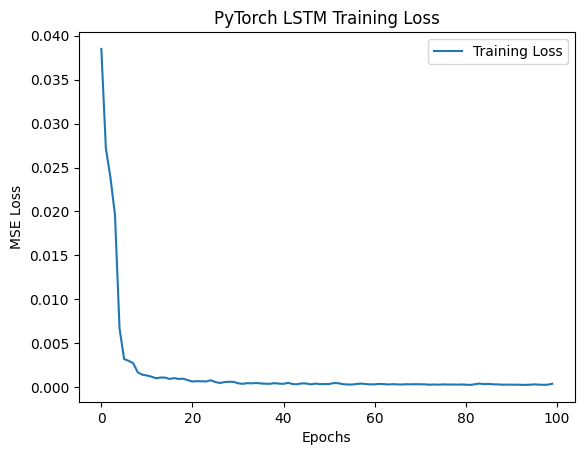

In [6]:
num_epochs = 100
loss_history = []

print("Starting Training on GPU...")

model.train() # Set to training mode

for epoch in range(num_epochs):
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        # 1. Forward Pass
        outputs = model(X_batch)
        loss = criterion(outputs.squeeze(), y_batch) # squeeze fixes dimension mismatch
        
        # 2. Backward Pass & Optimization
        optimizer.zero_grad() # Clear old gradients
        loss.backward()       # Calculate new gradients
        optimizer.step()      # Update weights
        
        epoch_loss += loss.item()
    
    # Store average loss
    avg_loss = epoch_loss / len(train_loader)
    loss_history.append(avg_loss)
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}')

# Plot Loss
plt.plot(loss_history, label='Training Loss')
plt.title('PyTorch LSTM Training Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

Model Accuracy (R2 Score): 0.6807


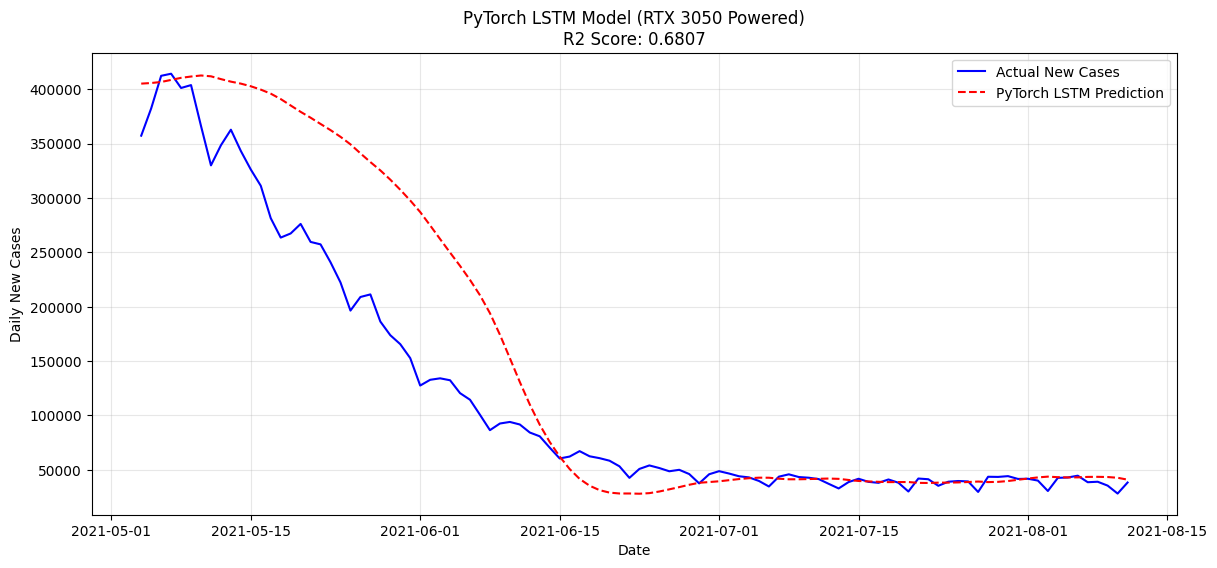

In [7]:
model.eval() # Set to evaluation mode

# 1. Predict (No gradient calculation needed)
with torch.no_grad():
    predictions = model(X_test_t).cpu().numpy() # Move back to CPU for plotting

# 2. Inverse Scaling
# Create dummy array to fit the scaler's expected shape (Samples, 2)
dummy_pred = np.zeros((len(predictions), 2))
dummy_pred[:, 0] = predictions.flatten()
inverse_pred = scaler.inverse_transform(dummy_pred)[:, 0]

# Inverse Scale Actual Values
dummy_actual = np.zeros((len(y_test), 2))
dummy_actual[:, 0] = y_test
inverse_actual = scaler.inverse_transform(dummy_actual)[:, 0]

# 3. Calculate Accuracy
r2 = r2_score(inverse_actual, inverse_pred)
print(f"Model Accuracy (R2 Score): {r2:.4f}")

# 4. Plot
test_dates = master_df['Date'].iloc[-len(inverse_actual):]

plt.figure(figsize=(14, 6))
plt.plot(test_dates, inverse_actual, color='blue', label='Actual New Cases')
plt.plot(test_dates, inverse_pred, color='red', linestyle='--', label='PyTorch LSTM Prediction')
plt.title(f'PyTorch LSTM Model (RTX 3050 Powered)\nR2 Score: {r2:.4f}')
plt.xlabel('Date')
plt.ylabel('Daily New Cases')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()